In [1]:
'''Modules import'''

import os
import re

#analyses audio. extracts the data
import time
import pickle
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt

#plays audio files
from IPython.display import Audio

#sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Keras
import keras
from keras.layers import Dense
from keras import regularizers
from keras.utils import np_utils
from tensorflow.keras import optimizers
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Convolution2D, MaxPool2D, Reshape, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization

%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

ModuleNotFoundError: No module named 'librosa'

# **Data Analysis**

In [5]:
## *Data Augmentation*

In [2]:
path_file = './Datasets/Emo-DB/wav/12a01Fb.wav'
data, sample_rate = librosa.load(path_file)
Audio(path_file)

In [3]:
def spec_graph(data):
    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(data, sr=sample_rate)
   

In [4]:
#Emotion Count
def emotion_distribution(data):

  plt.style.use("ggplot")

  plt.title("Emotion Data Distribution")
  sns.countplot(x=data["label"], palette="icefire")


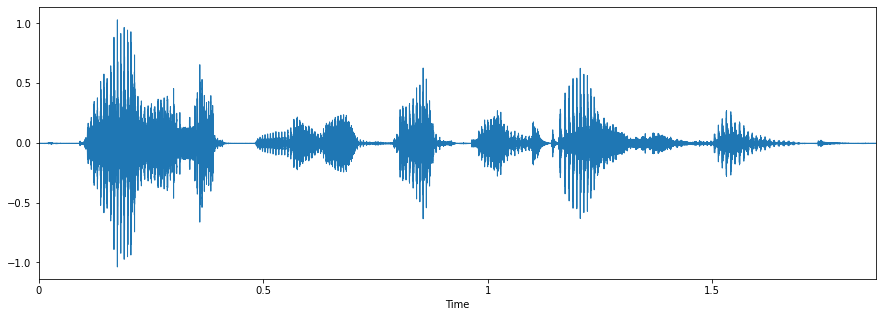

In [5]:
spec_graph(data)

### Noise

In [6]:
#White Noise
def noise(data):

    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data_noise = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])

    return data_noise

In [7]:
data_noise = noise(data)

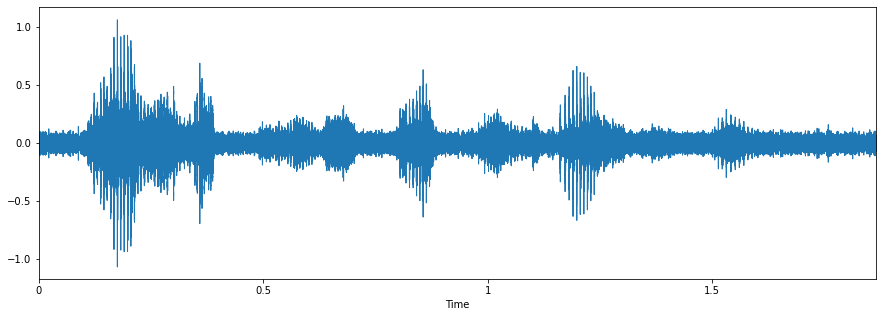

In [8]:
spec_graph(data_noise)

### Shifting

In [9]:
#Random Shifting
def shift(data):
  s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
  data_shift = np.roll(data, s_range)

  return data_shift

In [10]:
data_shift = shift(data)

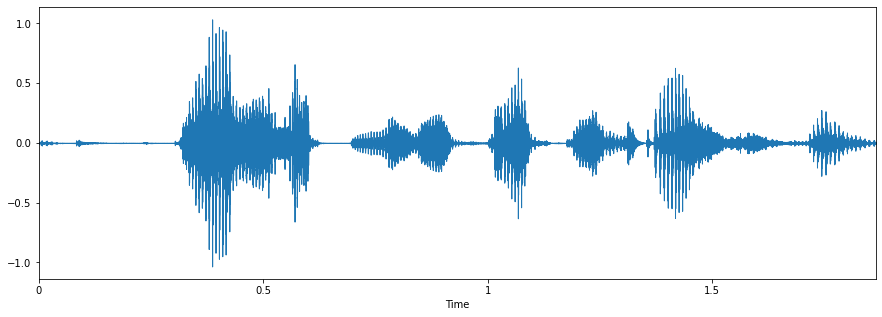

In [11]:
spec_graph(data_shift)

### Stretching

In [12]:
#Streching the Sound
def stretch(data, rate=0.8):
  
  data_stretch = librosa.effects.time_stretch(data, rate)

  return data_stretch

In [13]:
data_stretch = stretch(data)

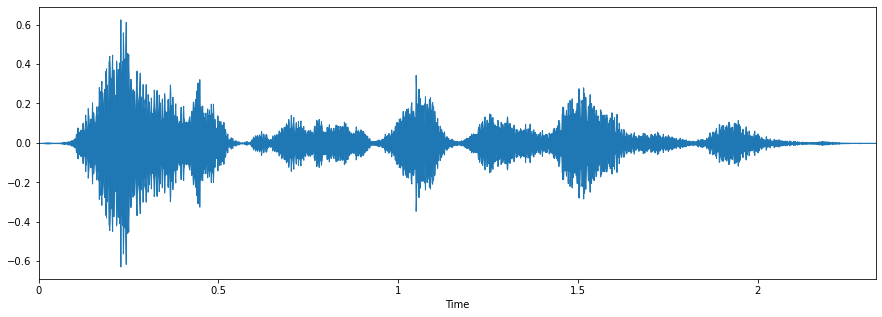

In [14]:
spec_graph(data_stretch)

### Pitch

In [15]:
#Pitch Tuning
def pitch(data):
  
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  data_pitch = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)

  return data_pitch

In [16]:
data_pitch = pitch(data)

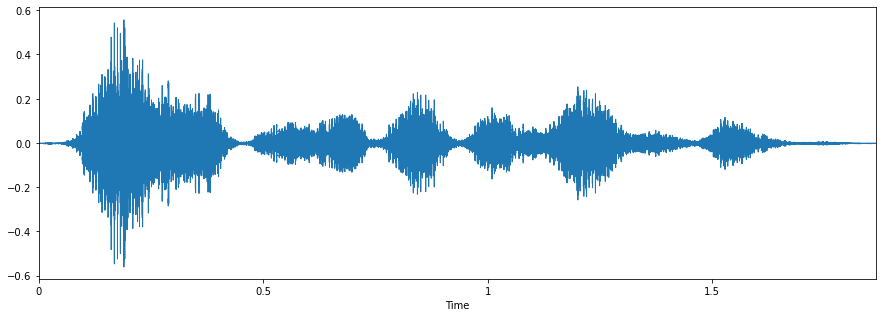

In [17]:
spec_graph(data_pitch)

### Speed and Pitch

In [18]:
#speed and Pitch Tuning
def speedNpitch(data):
  
  length_change = np.random.uniform(low=0.8, high = 1)
  speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
  tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
  minlen = min(data.shape[0], tmp.shape[0])
  data_speedNpitch = data * 0
  data_speedNpitch[0:minlen] = tmp[0:minlen]

  return data_speedNpitch

In [19]:
data_speedNpitch = speedNpitch(data)

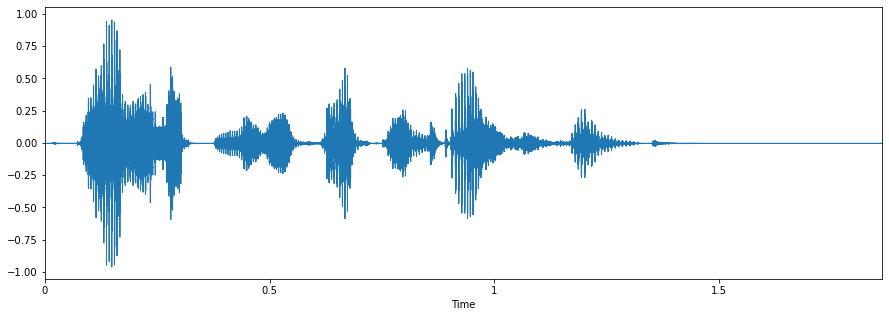

In [20]:
spec_graph(data_speedNpitch)

## *Feature Extraction*

### Mel

In [56]:
#Mel Spectogram
def mel_ft(data, hop_length=512, n_fft=2048):

  mel = librosa.feature.melspectrogram(data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=12)
  mel_power = librosa.power_to_db(mel)
  
  return mel, mel_power

In [22]:
def mel_graph(mel_power):

  librosa.display.specshow(mel_power, y_axis='mel', x_axis='time', cmap='plasma')
  plt.colorbar()
  plt.title('mel')
  plt.show()

In [57]:
mel, mel_power = mel_ft(data)

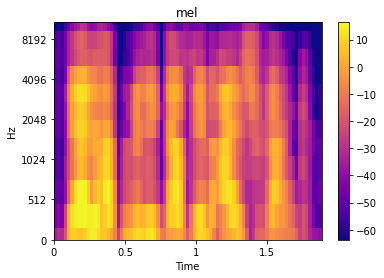

In [24]:
mel_graph(mel_power)

### Chroma

In [25]:
#chroma
def chroma_ft(data):

      stft = np.abs(librosa.stft(data))
      chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
      
      return chroma


In [26]:
chroma = chroma_ft(data)

In [27]:
def chroma_graph(chroma):
      plt.figure()
      librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
      plt.colorbar()
      plt.title('Chroma')
      plt.show()

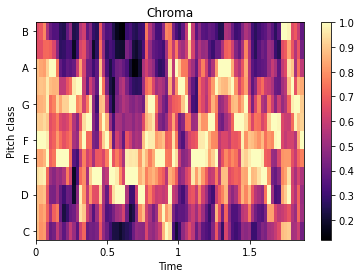

In [28]:
chroma_graph(chroma)

In [29]:
#Zero-crossing rate
def zcr_ft(data, hop_length=512):

  zcr = librosa.feature.zero_crossing_rate(data, hop_length=hop_length)

  # print("zcr Shape", zcr.shape)

  return zcr

In [30]:
zcr = zcr_ft(data)

### MFCC

In [95]:
#MFCCs
def mfccs_ft(data, sample_rate, hop_length=512):

  mfccs = librosa.feature.mfcc(data, sr= sample_rate, n_mfcc=12, hop_length=hop_length, n_fft=2048)

  return mfccs

In [96]:
def mfcc_graph(data):
  plt.figure()
  librosa.display.specshow(data, x_axis='time', cmap='plasma')
  plt.ylabel('MFCC')
  plt.colorbar()

In [97]:
mfccs = mfccs_ft(data, sample_rate)
mfccs.shape

(12, 81)

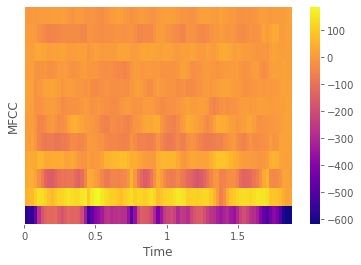

In [98]:
mfcc_graph(mfccs)

# **Data Preparation**

## *Emo-DB*

Data's shape:  (41093,)


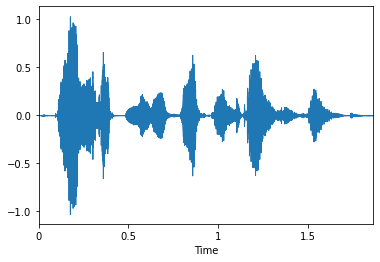

In [35]:
emo_path = './Datasets/Emo-DB/wav/12a01Fb.wav'
data_emo, sample_rate = librosa.load(emo_path)

print("Data's shape: ", data_emo.shape)

librosa.display.waveplot(data_emo, sr=sample_rate)
Audio(emo_path)

In [36]:

def get_audio_path_emo(audio_files_path):

  audio_emotion = []

  for f in os.listdir(audio_files_path):

    #removes ".wav" from file name
    #isolates emotion reference
    info = f.partition(".wav")[0]
    emotion_data = info[5]

    #checks for spaces in file name
    if ' ' not in f:

      #identifies emotion from reference
      if emotion_data == 'W':
        audio_emotion.append(("angry",  audio_files_path + f))
    
      if emotion_data == 'L':
        audio_emotion.append(("boredom", audio_files_path + f))
    
      if emotion_data == 'E':
        audio_emotion.append(("disgust", audio_files_path + f))
    
      if emotion_data == 'A':
        audio_emotion.append(("anxiety/fear", audio_files_path + f))
    
      if emotion_data == 'F':
        audio_emotion.append(("happiness", audio_files_path + f))
    
      if emotion_data == 'T':
        audio_emotion.append(("sadness", audio_files_path + f))
    
      if emotion_data == 'N':
        audio_emotion.append(("neutral", audio_files_path + f))

  audio_df = pd.DataFrame.from_dict(audio_emotion)
  audio_df.rename(columns={1 : "path", 0 : "label"}, inplace=True)   
  
  return audio_df



In [37]:
audio_emo_df = get_audio_path_emo('./Datasets/Emo-DB/wav/')

print(audio_emo_df.label.value_counts(), "\n")
audio_emo_df.head()

angry           127
boredom          81
neutral          79
happiness        71
anxiety/fear     69
sadness          62
disgust          46
Name: label, dtype: int64 



,label,path
0,boredom,./Datasets/Emo-DB/wav/16a02Lb.wav
1,angry,./Datasets/Emo-DB/wav/14a07Wc.wav
2,anxiety/fear,./Datasets/Emo-DB/wav/10a07Ad.wav
3,disgust,./Datasets/Emo-DB/wav/13a05Ea.wav
4,angry,./Datasets/Emo-DB/wav/14a05Wa.wav


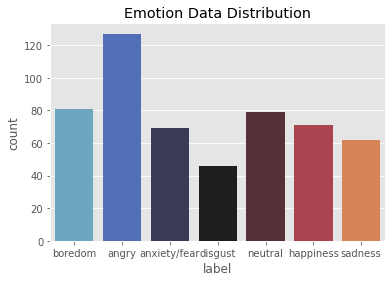

In [38]:
emotion_distribution(audio_emo_df)

## *Savee*

Data's shape:  (84595,)


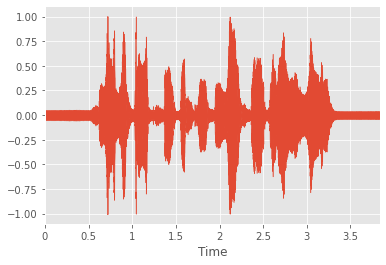

In [39]:
savee_path = './DataSets/SAVEE/DC_h01.wav'
data_savee, sample_rate = librosa.load(savee_path)

print("Data's shape: ", data_savee.shape)

librosa.display.waveplot(data_savee, sr=sample_rate)
Audio(savee_path)

In [40]:

def get_audio_path_savee(audio_files_path):

  audio_emotion = []

  for wav in os.listdir(audio_files_path):

      info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
      emotion = re.split(r"[0-9]", info)[0]
      
      if emotion=='a':
          audio_emotion.append(("angry", audio_files_path + wav))
      elif emotion=='d':
          audio_emotion.append(("disgust", audio_files_path + wav))
      elif emotion=='f':
          audio_emotion.append(("anxiety/fear", audio_files_path + wav))
      elif emotion=='h':
          audio_emotion.append(("happiness", audio_files_path + wav))
      elif emotion=='n':
          audio_emotion.append(("neutral", audio_files_path + wav))
      elif emotion=='sa':
          audio_emotion.append(("sadness", audio_files_path + wav))
      else:
          audio_emotion.append(("boredom", audio_files_path + wav))


  audio_df = pd.DataFrame.from_dict(audio_emotion)
  audio_df.rename(columns={1 : "path", 0 : "label"}, inplace=True)   
  
  return audio_df


In [41]:
audio_savee_df = get_audio_path_savee('./DataSets/SAVEE/')

print(audio_savee_df.label.value_counts(), "\n")
audio_savee_df.head()

neutral         120
sadness          60
boredom          60
anxiety/fear     60
disgust          60
happiness        60
angry            60
Name: label, dtype: int64 



,label,path
0,sadness,./DataSets/SAVEE/JK_sa01.wav
1,sadness,./DataSets/SAVEE/JK_sa15.wav
2,neutral,./DataSets/SAVEE/DC_n13.wav
3,boredom,./DataSets/SAVEE/DC_su09.wav
4,neutral,./DataSets/SAVEE/DC_n07.wav


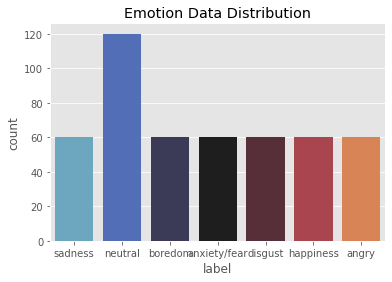

In [42]:
emotion_distribution(audio_savee_df)

## *Crema*

Data's shape:  (84595,)


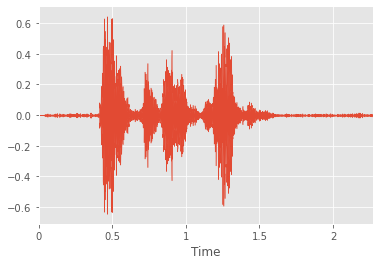

In [43]:
crema_path = './DataSets/CREMAD/1001_DFA_ANG_XX.wav'
data_crema, sample_rate_s = librosa.load(crema_path)

print("Data's shape: ", data_savee.shape)

librosa.display.waveplot(data_crema, sr=sample_rate)
Audio(crema_path)

In [44]:
def get_audio_path_crema(audio_files_path):

  audio_emotion = []

  for wav in os.listdir(audio_files_path):

      info = wav.partition(".wav")[0].split("_")
      emotion = info[2]
      
      if emotion=='ANG':
          audio_emotion.append(("angry", audio_files_path + wav))
      elif emotion=='DIS':
          audio_emotion.append(("disgust", audio_files_path + wav))
      elif emotion=='FEA':
          audio_emotion.append(("anxiety/fear", audio_files_path + wav))
      elif emotion=='HAP':
          audio_emotion.append(("happiness", audio_files_path + wav))
      elif emotion=='NEU':
          audio_emotion.append(("neutral", audio_files_path + wav))
      elif emotion=='SAD':
          audio_emotion.append(("sadness", audio_files_path + wav))
      else:
          audio_emotion.append(("boredom", audio_files_path + wav))


  audio_df = pd.DataFrame.from_dict(audio_emotion)
  audio_df.rename(columns={1 : "path", 0 : "label"}, inplace=True)   
  
  return audio_df

In [45]:
audio_crema_df = get_audio_path_crema('./DataSets/CREMAD/')

print(audio_crema_df.label.value_counts(), "\n")


angry           1271
disgust         1271
sadness         1271
anxiety/fear    1271
happiness       1271
neutral         1087
Name: label, dtype: int64 



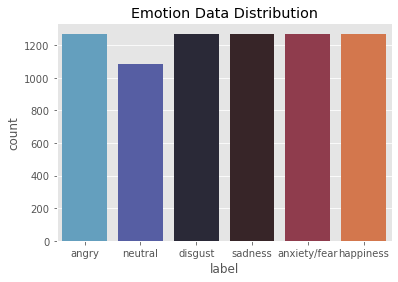

In [46]:
emotion_distribution(audio_crema_df)

## *Tess*

Data's shape:  (33936,)


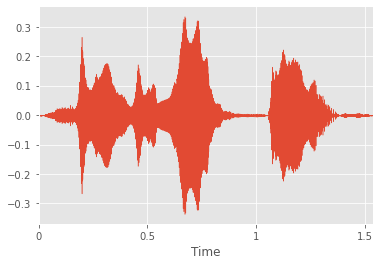

In [47]:
tess_path = './DataSets/TESS/wav/OAF_angry/OAF_back_angry.wav'
data_tess, sample_rate = librosa.load(tess_path)

print("Data's shape: ", data_tess.shape)

librosa.display.waveplot(data_tess, sr=sample_rate)
Audio(tess_path)

In [48]:
def get_audio_path_tess(audio_files_path):

  audio_emotion = []
  path = []

  for dir in os.listdir(audio_files_path):
    fname = os.listdir(audio_files_path + dir)
    for wav in fname:

      info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
      emotion = re.split(r"[0-9]", info)[0]
      
      if dir == 'OAF_angry' or dir == 'YAF_angry':
            audio_emotion.append(("angry", audio_files_path + dir + "/" + wav))

      elif dir == 'OAF_disgust' or dir == 'YAF_disgust':
            audio_emotion.append(("disgust", audio_files_path + dir + "/" + wav))

      elif dir == 'OAF_Fear' or dir == 'YAF_fear':
            audio_emotion.append(("anxiety/fear", audio_files_path + dir + "/" + wav))
      
      elif dir == 'OAF_happy' or dir == 'YAF_happy':
            audio_emotion.append(("hapiness", audio_files_path + dir + "/" + wav))
        
      elif dir == 'OAF_neutral' or dir == 'YAF_neutral':
        audio_emotion.append(("neutral", audio_files_path + dir + "/" + wav))

      elif dir == 'OAF_Pleasant_surprise' or dir == 'YAF_pleasant_surprised':
            audio_emotion.append(("boredom", audio_files_path + dir + "/" + wav))
       
      elif dir == 'OAF_Sad' or dir == 'YAF_sad':
            audio_emotion.append(("sadness", audio_files_path + dir + "/" + wav))
        
      else:
            audio_emotion.append('Unknown')
      


  audio_df = pd.DataFrame.from_dict(audio_emotion)
  audio_df.rename(columns={1 : "path", 0 : "label"}, inplace=True)   
  
  return audio_df

In [49]:
audio_tess_df = get_audio_path_tess('./DataSets/TESS/wav/')


print(audio_tess_df.label.value_counts(), "\n")
audio_tess_df.head()

disgust         400
boredom         400
hapiness        400
sadness         400
neutral         400
anxiety/fear    400
angry           400
Name: label, dtype: int64 



,label,path
0,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_date_disgu...
1,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_rag_disgus...
2,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_raise_disg...
3,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_ditch_disg...
4,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_door_disgu...


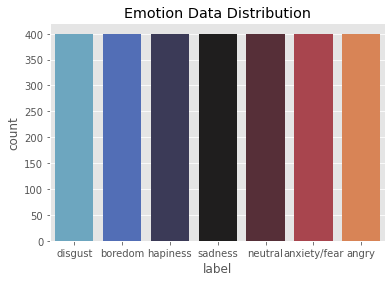

In [50]:
emotion_distribution(audio_tess_df)

## *Create Final File*

In [51]:
df = pd.concat([audio_tess_df, audio_crema_df, audio_savee_df, audio_emo_df], axis = 0)
print(df.label.value_counts())
df.to_csv("./Data_path.csv", index=False)
df.head()

angry           1858
anxiety/fear    1800
sadness         1793
disgust         1777
neutral         1686
happiness       1402
boredom          541
hapiness         400
Name: label, dtype: int64


,label,path
0,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_date_disgu...
1,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_rag_disgus...
2,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_raise_disg...
3,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_ditch_disg...
4,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_door_disgu...


# **Data Pre-Processing**

In [52]:
ref = pd.read_csv("./Data_path.csv")
ref.shape

(11257, 2)

In [68]:
tic = time.perf_counter()

mfcc_df = pd.DataFrame(columns=['feature_mfcc'])
mel_df = pd.DataFrame(columns=['feature_mel'])
chroma_df = pd.DataFrame(columns=['feature_chroma'])

#2D
mfccs_df2 = np.empty(shape=(ref.shape[0], 12, 173))
chroma_df2 = np.empty(shape=(ref.shape[0], 12, 173))
mel_df2 = np.empty(shape=(ref.shape[0], 12, 173))


counter=0

print("------------------------------------------")
print("Processing...")

for i, path in enumerate(ref.path):
    
    tac = time.perf_counter()
    
    audio_data, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2, sr=44100, offset=0.5)
    sample_rate = np.array(sample_rate)

    mel, mel_power = mel_ft(audio_data)
    chroma = chroma_ft(audio_data)
    mfccs = mfccs_ft(audio_data, sample_rate)

    # mel_df.loc[counter] = [np.mean(mel.T, axis=0)]
    # chroma_df.loc[counter] = [np.mean(chroma.T, axis=0)]
    # mfcc_df.loc[counter] = [np.mean(mfccs.T, axis=0)]

    #2D
    mfccs_df2[counter, 0:12, 0:mfccs.shape[1]] = mfccs
    chroma_df2[counter, 0:12, 0:chroma.shape[1]] = chroma
    mel_df2[counter, 0:12, 0:mel_power.shape[1]] = mel_power

    counter=counter+1
    
    toc = time.perf_counter()
    print("...............................")
    print(f"Time: {toc - tac:0.4f} seconds")
    print(f"{i} out of {len(ref)}")
    print("...............................")

tec = time.perf_counter()
print(f"Time: {tec - tic:0.4f} seconds")
print("Done")
print("------------------------------------------ \n")


------------------------------------------
Processing...
...............................
Time: 0.2572 seconds
0 out of 11257
...............................
...............................
Time: 0.2149 seconds
1 out of 11257
...............................
...............................
Time: 0.1690 seconds
2 out of 11257
...............................
...............................
Time: 0.1522 seconds
3 out of 11257
...............................
...............................
Time: 0.1517 seconds
4 out of 11257
...............................
...............................
Time: 0.1179 seconds
5 out of 11257
...............................
...............................
Time: 0.1186 seconds
6 out of 11257
...............................
...............................
Time: 0.1819 seconds
7 out of 11257
...............................
...............................
Time: 0.1492 seconds
8 out of 11257
...............................
...............................
Time: 0.128

/Users/sofiavalente/anaconda3/envs/my-env/lib/python3.9/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


...............................
Time: 0.1844 seconds
7453 out of 11257
...............................
...............................
Time: 0.1509 seconds
7454 out of 11257
...............................
...............................
Time: 0.1359 seconds
7455 out of 11257
...............................
...............................
Time: 0.0762 seconds
7456 out of 11257
...............................
...............................
Time: 0.1062 seconds
7457 out of 11257
...............................
...............................
Time: 0.0671 seconds
7458 out of 11257
...............................
...............................
Time: 0.1360 seconds
7459 out of 11257
...............................
...............................
Time: 0.1463 seconds
7460 out of 11257
...............................
...............................
Time: 0.1263 seconds
7461 out of 11257
...............................
...............................
Time: 0.3971 seconds
7462 out of 11257
..

In [69]:
df2 = np.concatenate([mfccs_df2, chroma_df2, mel_df2], -2)


In [71]:
df = pd.concat([ref,
                  pd.DataFrame(mfcc_df['feature_mfcc'].values.tolist()),
                  pd.DataFrame(chroma_df['feature_chroma'].values.tolist()),
                  pd.DataFrame(mel_df['feature_mel'].values.tolist())],
                  axis=1)

print(df.shape)
df[:5]

(11257, 27)


,label,path,0,1,2,3,4,5,6,7,...,3,4,5,6,7,8,9,10,11,0
0,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_date_disgu...,-506.689758,119.705452,-23.903784,46.241364,13.637174,-3.469023,-1.058452,-5.195559,...,0.605241,0.617429,0.651539,0.645988,0.653734,0.569180,0.565375,0.587578,0.555637,0.375264
1,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_rag_disgus...,-446.944580,152.169632,-25.071270,24.370699,1.614857,-2.658126,-5.733555,-12.947874,...,0.516570,0.567328,0.608416,0.639490,0.615214,0.568711,0.528395,0.578357,0.579501,0.760035
2,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_raise_disg...,-454.346313,137.890610,-18.902941,39.916019,2.026384,-2.130992,-8.059580,-11.917194,...,0.513504,0.571202,0.649541,0.642297,0.559825,0.513550,0.498652,0.481467,0.459905,1.031759
3,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_ditch_disg...,-503.703339,117.168129,-31.628269,43.646217,3.323801,-2.862889,5.463549,-9.874079,...,0.623383,0.584386,0.579672,0.595781,0.611336,0.594309,0.590776,0.615692,0.622993,0.357666
4,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_door_disgu...,-483.030212,143.444382,10.049400,18.550903,-4.993419,-2.609169,2.181819,-4.920048,...,0.528132,0.551537,0.559861,0.570913,0.588259,0.551699,0.491616,0.498786,0.499624,1.374793




# **Data Training**

In [72]:
df=df.fillna(0)
print(df.shape)
df[:5]

(11257, 27)


,label,path,0,1,2,3,4,5,6,7,...,3,4,5,6,7,8,9,10,11,0
0,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_date_disgu...,-506.689758,119.705452,-23.903784,46.241364,13.637174,-3.469023,-1.058452,-5.195559,...,0.605241,0.617429,0.651539,0.645988,0.653734,0.569180,0.565375,0.587578,0.555637,0.375264
1,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_rag_disgus...,-446.944580,152.169632,-25.071270,24.370699,1.614857,-2.658126,-5.733555,-12.947874,...,0.516570,0.567328,0.608416,0.639490,0.615214,0.568711,0.528395,0.578357,0.579501,0.760035
2,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_raise_disg...,-454.346313,137.890610,-18.902941,39.916019,2.026384,-2.130992,-8.059580,-11.917194,...,0.513504,0.571202,0.649541,0.642297,0.559825,0.513550,0.498652,0.481467,0.459905,1.031759
3,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_ditch_disg...,-503.703339,117.168129,-31.628269,43.646217,3.323801,-2.862889,5.463549,-9.874079,...,0.623383,0.584386,0.579672,0.595781,0.611336,0.594309,0.590776,0.615692,0.622993,0.357666
4,disgust,./DataSets/TESS/wav/YAF_disgust/YAF_door_disgu...,-483.030212,143.444382,10.049400,18.550903,-4.993419,-2.609169,2.181819,-4.920048,...,0.528132,0.551537,0.559861,0.570913,0.588259,0.551699,0.491616,0.498786,0.499624,1.374793


In [73]:
df2=np.nan_to_num(df2)
print(df2.shape)

(11257, 36, 173)


## *Train*

In [74]:
#Train and test dataset division
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','label'],axis=1)
                                                    , df.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


X_train.shape

(8442, 25)

In [75]:
#Data for 2D
x_train, x_test, Y_train, Y_test = train_test_split(df2, ref.label, test_size = 0.25, random_state = 42)

x_shape = x_train

print(x_train.shape)

(8442, 36, 173)


## *Feature Scalling*

In [76]:
#Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape: ", X_train.shape)

X_train shape:  (8442, 25)


## *Label Encoder*

In [77]:
#Label Encoder
def label_encoder(X_train, X_test, y_train, y_test):
  
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  # one hot encode the target 
  lb = LabelEncoder()
  y_train = np_utils.to_categorical(lb.fit_transform(y_train))
  y_test = np_utils.to_categorical(lb.fit_transform(y_test))

  print(lb.classes_)

  # Pickel the lb object for future use 
  filename = 'label'
  outfile = open(filename,'wb')
  pickle.dump(lb,outfile)
  outfile.close()

  return X_train, X_test, y_train, y_test, lb

# **Data Modelling**

## *SVM*

In [78]:

plot_labels = ['angry', 'anxiety/fear', 'boredom', 'disgust', 'happiness', 'neutral', 'sadness']
  
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 

svm_accuracy = accuracy_score(y_true=y_test, y_pred=svm_predictions)
svm_classification = classification_report(y_test,svm_predictions)
  
print("------------------------------------------")
print("Accuracy:", svm_accuracy*100 , "%")
print("Classification: \n", svm_classification) 


------------------------------------------
Accuracy: 51.47424511545293 %
Classification: 
               precision    recall  f1-score   support

       angry       0.59      0.73      0.65       484
anxiety/fear       0.42      0.35      0.38       443
     boredom       0.63      0.58      0.60       137
     disgust       0.42      0.32      0.36       439
    hapiness       0.84      0.81      0.83        94
   happiness       0.39      0.31      0.34       360
     neutral       0.50      0.54      0.52       391
     sadness       0.55      0.70      0.61       467

    accuracy                           0.51      2815
   macro avg       0.54      0.54      0.54      2815
weighted avg       0.50      0.51      0.50      2815



([<matplotlib.axis.YTick at 0x7fd5efe78370>,
 [Text(0, 0, 'angry'),
  Text(0, 1, 'anxiety/fear'),
  Text(0, 2, 'boredom'),
  Text(0, 3, 'disgust'),
  Text(0, 4, 'happiness'),
  Text(0, 5, 'neutral'),
  Text(0, 6, 'sadness')])

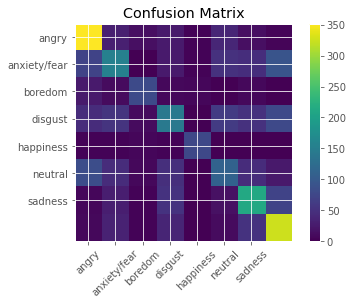

In [79]:
#Confusion matrix
svm_conf_matrix = pd.DataFrame(confusion_matrix(y_test, svm_predictions))

fig, ax = plt.subplots()
im = ax.imshow(svm_conf_matrix, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
plt.title("Confusion Matrix")

tick_marks = np.arange(len(plot_labels))
plt.xticks(tick_marks, plot_labels, rotation=45)
plt.yticks(tick_marks, plot_labels)


## *CNN*

In [80]:
X_train, X_test, y_train, y_test, lb = label_encoder(X_train, X_test, y_train, y_test)

['angry' 'anxiety/fear' 'boredom' 'disgust' 'hapiness' 'happiness'
 'neutral' 'sadness']


In [81]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(8442, 25, 1)

In [82]:
#CNN 1D
def cnn(X_train):
  
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
  model.add(Activation('relu'))

  model.add(Conv1D(256, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(3)))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Flatten())
  model.add(Dense(8)) # Target class number
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model_history=model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

  model.summary()

  return model, model_history



In [83]:
cnn_model, cnn_model_history = cnn(X_train)

Epoch 1/100
132/132 [==============================] - 20s 120ms/step - loss: 2.0340 - accuracy: 0.2165 - val_loss: 2.0774 - val_accuracy: 0.2334
Epoch 2/100
132/132 [==============================] - 16s 118ms/step - loss: 1.9639 - accuracy: 0.2909 - val_loss: 2.0701 - val_accuracy: 0.2320
Epoch 3/100
132/132 [==============================] - 16s 121ms/step - loss: 1.8990 - accuracy: 0.3188 - val_loss: 2.0390 - val_accuracy: 0.2622
Epoch 4/100
132/132 [==============================] - 16s 121ms/step - loss: 1.8319 - accuracy: 0.3693 - val_loss: 1.9431 - val_accuracy: 0.3258
Epoch 5/100
132/132 [==============================] - 16s 121ms/step - loss: 1.7669 - accuracy: 0.4104 - val_loss: 1.8145 - val_accuracy: 0.4078
Epoch 6/100
132/132 [==============================] - 16s 120ms/step - loss: 1.7008 - accuracy: 0.4288 - val_loss: 1.7149 - val_accuracy: 0.4416
Epoch 7/100
132/132 [==============================] - 16s 119ms/step - loss: 1.6392 - accuracy: 0.4424 - val_loss: 1.6461 -

## CNN 2D

In [ ]:
x_train, x_test, Y_train, Y_test, lb = label_encoder(x_train, x_test, Y_train, Y_test)

['angry' 'anxiety/fear' 'boredom' 'disgust' 'hapiness' 'happiness'
 'neutral' 'sadness']


In [ ]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape

(8442, 36, 173, 1)

In [3]:
#CNN 2D
def cnn2D(x_train):

  model = Sequential()
  input = [x_train.shape[1],x_train.shape[2], 1]
  model.add(Input(shape=input))

  model.add(Convolution2D(filters=256, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D())
  model.add(Dropout(0.25))

  model.add(Convolution2D(filters=256, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D())
  model.add(Dropout(0.25))

  model.add(Convolution2D(filters=128, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D())

  model.add(Convolution2D(filters=128, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D(1))

  model.add(Flatten())
  model.add(Dense(64)) 
  model.add(Dropout(0.25))

  model.add(Dense(8)) 
  model.add(Activation('softmax'))

  opt = optimizers.Adam(0.001)
  # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model_history=model.fit(x_train, Y_train, batch_size=64, epochs=100, validation_data=(x_test, Y_test))

  model.summary()

  return model, model_history


In [ ]:
cnn2D_model, cnn2D_model_history = cnn2D(x_train)

Epoch 1/100
  8/132 [>.............................] - ETA: 19:32 - loss: 12.4486 - accuracy: 0.1602

KeyboardInterrupt: 

## LSTM

In [88]:
#LSTM

def lstm(X_train):
  model = Sequential()

  model.add(LSTM(128, input_shape=( X_train.shape[1], 1), return_sequences=True))
  model.add(LSTM(64))
  
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Activation('relu'))

  model.add(Dense(8, activation='softmax'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model_history=model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

  model.summary()

  
  return model, model_history


In [89]:
LSTM_model, LSTM_model_history = lstm(X_train)

Epoch 1/100
132/132 [==============================] - 8s 41ms/step - loss: 2.0712 - accuracy: 0.1778 - val_loss: 2.0622 - val_accuracy: 0.2281
Epoch 2/100
132/132 [==============================] - 5s 35ms/step - loss: 2.0570 - accuracy: 0.1921 - val_loss: 2.0464 - val_accuracy: 0.2291
Epoch 3/100
132/132 [==============================] - 5s 35ms/step - loss: 2.0397 - accuracy: 0.2028 - val_loss: 2.0238 - val_accuracy: 0.2178
Epoch 4/100
132/132 [==============================] - 4s 34ms/step - loss: 2.0130 - accuracy: 0.2073 - val_loss: 1.9888 - val_accuracy: 0.2135
Epoch 5/100
132/132 [==============================] - 4s 32ms/step - loss: 1.9798 - accuracy: 0.2024 - val_loss: 1.9479 - val_accuracy: 0.2075
Epoch 6/100
132/132 [==============================] - 4s 28ms/step - loss: 1.9501 - accuracy: 0.1964 - val_loss: 1.9170 - val_accuracy: 0.2131
Epoch 7/100
132/132 [==============================] - 4s 27ms/step - loss: 1.9328 - accuracy: 0.1959 - val_loss: 1.8998 - val_accuracy:

## CNN 1D + LSTM

In [90]:
#CNN 1D
def cnn1D_LSTM(X_train):
  
  model = Sequential()
 # LFLB1
  model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',
                     input_shape=(X_train.shape[1], 1)))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling1D(pool_size=8, strides=4))

    # LFLB2
  model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))

    # LFLB3
  model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))

    # LFLB4
  model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))

  # LSTM
  model.add(LSTM(256, return_sequences=True))
  model.add(LSTM(128))

  model.add(Flatten())
  model.add(Dense(8)) # Target class number
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model_history=model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

  model.summary()

  return model, model_history

In [91]:
cnn1D_LSTM_model, cnn1D_LSTM_model_history = cnn1D_LSTM(X_train)


Epoch 1/100
132/132 [==============================] - 8s 33ms/step - loss: 2.0072 - accuracy: 0.2769 - val_loss: 2.0361 - val_accuracy: 0.1297
Epoch 2/100
132/132 [==============================] - 4s 28ms/step - loss: 1.9033 - accuracy: 0.3159 - val_loss: 1.9398 - val_accuracy: 0.1968
Epoch 3/100
132/132 [==============================] - 4s 28ms/step - loss: 1.8210 - accuracy: 0.3279 - val_loss: 1.8029 - val_accuracy: 0.3229
Epoch 4/100
132/132 [==============================] - 4s 28ms/step - loss: 1.7500 - accuracy: 0.3509 - val_loss: 1.7041 - val_accuracy: 0.3684
Epoch 5/100
132/132 [==============================] - 4s 28ms/step - loss: 1.6913 - accuracy: 0.3711 - val_loss: 1.6411 - val_accuracy: 0.3968
Epoch 6/100
132/132 [==============================] - 4s 28ms/step - loss: 1.6361 - accuracy: 0.3927 - val_loss: 1.5891 - val_accuracy: 0.4085
Epoch 7/100
132/132 [==============================] - 4s 27ms/step - loss: 1.5891 - accuracy: 0.4051 - val_loss: 1.5455 - val_accuracy:

## CNN 2D + LSTM

In [ ]:
#CNN 2D + LSTM
def cnn2D_lstm(x_train):

  model = Sequential()
  input = [x_train.shape[1],x_train.shape[2], 1]
  model.add(Input(shape=input))

  model.add(Convolution2D(filters=256, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D())
  model.add(Dropout(0.25))

  model.add(Convolution2D(filters=256, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D())
  model.add(Dropout(0.25))

  model.add(Convolution2D(filters=128, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D())

  model.add(Convolution2D(filters=128, kernel_size=(4, 10), strides=1, padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D(1))

  model.add(Flatten())
  model.add(Reshape((-1, 128)))
  model.add(Dropout(0.25))

  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(64))

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(8)) 
  model.add(Activation('softmax'))

  opt = optimizers.Adam(0.001)
  # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model_history=model.fit(x_train, Y_train, batch_size=64, epochs=100, validation_data=(x_test, Y_test))

  model.summary()
  
  return model, model_history


In [99]:
cnn2D_LSTM_model, cnn2D_LSTM_model_history = cnn2D_lstm(x_train)

Epoch 1/100
132/132 [==============================] - 1486s 11s/step - loss: 1.7934 - accuracy: 0.2902 - val_loss: 2.3288 - val_accuracy: 0.1698
Epoch 2/100
132/132 [==============================] - 1433s 11s/step - loss: 1.6471 - accuracy: 0.3507 - val_loss: 1.8927 - val_accuracy: 0.2636
Epoch 3/100
132/132 [==============================] - 1417s 11s/step - loss: 1.5229 - accuracy: 0.4041 - val_loss: 1.5254 - val_accuracy: 0.4114
Epoch 4/100
132/132 [==============================] - 1415s 11s/step - loss: 1.4030 - accuracy: 0.4457 - val_loss: 2.1453 - val_accuracy: 0.2433
Epoch 5/100
132/132 [==============================] - 1407s 11s/step - loss: 1.3436 - accuracy: 0.4665 - val_loss: 1.3121 - val_accuracy: 0.4831
Epoch 6/100
132/132 [==============================] - 1395s 11s/step - loss: 1.2890 - accuracy: 0.4884 - val_loss: 1.2097 - val_accuracy: 0.5254
Epoch 7/100
132/132 [==============================] - 1422s 11s/step - loss: 1.2506 - accuracy: 0.5072 - val_loss: 1.2463 -

# Results

In [ ]:
#Loss and Accuracy comparison of traning set

def graphs_loss_acc(model_history):

  epochs = [i for i in range(100)]
  fig , ax = plt.subplots(1,2)
  train_acc = model_history.history['accuracy']
  train_loss = model_history.history['loss']
  test_acc = model_history.history['val_accuracy']
  test_loss = model_history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()


In [ ]:
graphs_loss_acc(cnn_model_history)
graphs_loss_acc(cnn2D_model_history)
graphs_loss_acc(LSTM_model_history)
graphs_loss_acc(cnn2D_LSTM_model_history)

In [ ]:
#Predictions

def prediction(model, X_test, y_test):
  pred = model.predict(X_test)
  pred = pred.argmax(axis=1)

  y_pred = pred.astype(int).flatten()
  y_pred = lb.inverse_transform(y_pred)
  y_pred = pd.DataFrame({'predictedvalues': y_pred})

  actual=y_test.argmax(axis=1)
  actual = actual.astype(int).flatten()
  actual = (lb.inverse_transform((actual)))
  actual = pd.DataFrame({'actualvalues': actual})

  y_check = np.argmax(y_test, axis=1)

  finaldf = actual.join(y_pred)
  finaldf[170:180]

  return y_check, y_pred, finaldf


In [ ]:
cnn_y_check, cnn_y_pred, cnn_finaldf = prediction(cnn_model, X_test, y_test)
cnn2D_y_check, cnn2D_y_pred, cnn2D_finaldf = prediction(cnn2D_model, X_test, y_test)
LSTM_y_check, LSTM_y_pred, LSTM_finaldf = prediction(LSTM_model, X_test, y_test)
cnn2D_LSTM_y_check, cnn2D_LSTM_y_pred, cnn2D_LSTM_finaldf = prediction(cnn2D_LSTM_model, X_test, y_test)

In [ ]:
#Score
def score(model, X_test, y_test):

  score = model.evaluate(X_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))



In [ ]:
score(cnn_model, X_test, y_test)
score(cnn2D_model, X_test, y_test)
score(LSTM_model, X_test, y_test)
score(cnn2D_LSTM_model, X_test, y_test)

In [ ]:
#Confusion matrix
def conf_matrix_graph(finaldf, plot_labels):
  
  conf_matrix = pd.DataFrame(confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues,))

  fig, ax = plt.subplots()
  im = ax.imshow(conf_matrix, interpolation='nearest')
  ax.figure.colorbar(im, ax=ax)
  plt.title("Confusion Matrix")

  tick_marks = np.arange(len(plot_labels))
  plt.xticks(tick_marks, plot_labels, rotation=45)
  plt.yticks(tick_marks, plot_labels)


In [ ]:
conf_matrix_graph(cnn_finaldf, plot_labels)
conf_matrix_graph(cnn2D_finaldf, plot_labels)
conf_matrix_graph(LSTM_finaldf, plot_labels)
conf_matrix_graph(cnn2D_LSTM_finaldf, plot_labels)

In [ ]:
#Classification report
def class_report(finaldf):
  classes = finaldf.actualvalues.unique()
  classes.sort()    
  
  print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))
  

In [ ]:
class_report(cnn_finaldf)
class_report(cnn2D_finaldf)
class_report(LSTM_finaldf)
class_report(cnn2D_LSTM_finaldf)